In [13]:
import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split

def is_uppercase(stem):
    """
    Returns True if the filename stem starts with an uppercase letter,
    which we use to mean it's a cat image.
    """
    if not stem:
        return False
    return stem[0].isupper()

def colorize_label(label_img, include_boundary=False):
    """
    Converts a numeric mask (PIL Image in 'L') into an RGB image.
    For include_boundary==False, the expected classes are:
      0: background -> black
      1: cat       -> orange
      2: dog       -> cyan
    For include_boundary==True, we expect an additional class:
      3: boundary  -> white
    """
    arr = np.array(label_img)
    color_arr = np.zeros((arr.shape[0], arr.shape[1], 3), dtype=np.uint8)
    if include_boundary:
        color_map = {
            0: (0,   0,   0),      # background = black
            1: (255, 165, 0),      # cat = orange
            2: (0,   255, 255),    # dog = cyan
            3: (255, 255, 255)     # boundary = white
        }
    else:
        color_map = {
            0: (0, 0, 0),
            1: (255, 165, 0),
            2: (0, 255, 255)
        }
    for class_val, color in color_map.items():
        color_arr[arr == class_val] = color
    return Image.fromarray(color_arr, mode="RGB")

def convert_label_to_three_classes(label_img, is_cat):
    """
    For TrainVal:
    Convert a grayscale label (mode "L") that may contain:
      - 0 for background,
      - 255 for boundary,
      - values in (1..254) for the animal region,
    into a new label with:
      - 0 for background (and boundary merged),
      - 1 for cat (if is_cat True),
      - 2 for dog (if is_cat False).
    """
    arr = np.array(label_img, dtype=np.uint8)
    new_label = np.zeros_like(arr, dtype=np.uint8)
    if is_cat:
        new_label[(arr > 0) & (arr < 255)] = 1
    else:
        new_label[(arr > 0) & (arr < 255)] = 2
    return Image.fromarray(new_label)

def convert_label_test(label_img, is_cat):
    """
    For Test:
    Convert an RGB label image (that contains a boundary) into a numeric mask with 4 classes:
      0 = background (black)
      3 = boundary (white; pixels where R=G=B=255)
      For the remaining animal region, assign:
          1 if is_cat is True (cat),
          2 if is_cat is False (dog).
    """
    arr = np.array(label_img)
    # Create a single-channel mask
    mask = np.zeros(arr.shape[:2], dtype=np.uint8)
    # Background: where pixel is black
    background = (arr[:,:,0] == 0) & (arr[:,:,1] == 0) & (arr[:,:,2] == 0)
    mask[background] = 0
    # Boundary: where pixel is white
    boundary = (arr[:,:,0] == 255) & (arr[:,:,1] == 255) & (arr[:,:,2] == 255)
    mask[boundary] = 3
    # Animal region: everything that is not background or boundary
    animal = ~(background | boundary)
    if is_cat:
        mask[animal] = 1
    else:
        mask[animal] = 2
    return Image.fromarray(mask)

# --------------------------
# Resizing and Padding Classes
# --------------------------

class ResizeWithPadding:
    """For color images. Uses bilinear interpolation."""
    def __init__(self, target_size=512, padding_mode='mean', force_resize=True, resize_dims=(128, 128)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims
        assert padding_mode in ['mean', 'reflect', 'hybrid'], "Padding mode must be 'mean', 'reflect', or 'hybrid'"
        self.padding_mode = padding_mode

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        if self.padding_mode == 'mean':
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        elif self.padding_mode == 'reflect':
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
        else:
            reflected = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(reflected, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        return padded_image

    def __call__(self, img):
        arr = np.array(img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

class ResizeWithPaddingLabel:
    """For label images. Uses nearest-neighbor interpolation."""
    def __init__(self, target_size=512, force_resize=False, resize_dims=(256, 256)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w*scale), int(h*scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    def __call__(self, label_img):
        arr = np.array(label_img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

# --------------------------
# Augmentation Function for Synchronized Transforms
# --------------------------

def elastic_transform_pair(image, label, alpha=34, sigma=4):
    """Apply elastic transformation to both image and label."""
    np_img = np.array(image)
    np_label = np.array(label)
    random_state = np.random.RandomState(None)
    shape = np_img.shape[:2]
    dx = (random_state.rand(*shape) * 2 - 1)
    dy = (random_state.rand(*shape) * 2 - 1)
    dx = cv2.GaussianBlur(dx, (17,17), sigma) * alpha
    dy = cv2.GaussianBlur(dy, (17,17), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x+dx).astype(np.float32)
    map_y = (y+dy).astype(np.float32)
    transformed_img = cv2.remap(np_img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    transformed_label = cv2.remap(np_label, map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return Image.fromarray(transformed_img), Image.fromarray(transformed_label)

def augment_pair(image, label, size=(256,256), apply_color=True, **params):
    """
    Applies a random subset of augmentations in random order.
    """
    augmentations = []
    augmentations.append((lambda img, lbl: (F.hflip(img), F.hflip(lbl)), params.get("flip_prob",0.5)))
    def rotate_aug(img, lbl):
        angle = random.uniform(-params.get("rotation_angle",5), params.get("rotation_angle",45))
        return F.rotate(img, angle, interpolation=Image.BILINEAR), F.rotate(lbl, angle, interpolation=Image.NEAREST)
    augmentations.append((rotate_aug, params.get("rotation_prob",0.25)))
    def translate_aug(img, lbl):
        max_translate = params.get("translate_factor", 0.05)*size[0]
        tx = int(random.uniform(-max_translate, max_translate))
        ty = int(random.uniform(-max_translate, max_translate))
        return (F.affine(img, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.BILINEAR),
                F.affine(lbl, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.NEAREST))
    augmentations.append((translate_aug, params.get("translate_prob",0.05)))
    def crop_aug(img, lbl):
        i,j,h,w = transforms.RandomResizedCrop.get_params(img, scale=params.get("crop_scale_range",(0.9,1.0)), ratio=params.get("crop_ratio_range",(1.0,1.0)))
        return (F.resized_crop(img, i,j,h,w,size, interpolation=Image.BILINEAR),
                F.resized_crop(lbl, i,j,h,w,size, interpolation=Image.NEAREST))
    augmentations.append((crop_aug, params.get("crop_prob",0.01)))
    def elastic_aug(img, lbl):
        return elastic_transform_pair(img, lbl, alpha=params.get("elastic_alpha",15), sigma=params.get("elastic_sigma",2))
    augmentations.append((elastic_aug, params.get("elastic_prob",0.01)))
    def scaling_aug(img, lbl):
        scale_factor = random.uniform(*params.get("scaling_range",(0.0,0.0)))
        new_size = (int(size[0]*scale_factor), int(size[1]*scale_factor))
        return (F.resize(img, new_size, interpolation=Image.BILINEAR),
                F.resize(lbl, new_size, interpolation=Image.NEAREST))
    augmentations.append((scaling_aug, params.get("scaling_prob",0.0)))
    def color_aug(img, lbl):
        if random.random() < params.get("blur_prob",0.0):
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(*params.get("blur_radius_range",(0.5,1.5)))))
        color_jitter = transforms.ColorJitter(**params.get("color_jitter_params",{'brightness':0.2,'contrast':0.2,'saturation':0.2,'hue':0.1}))
        img = color_jitter(img)
        return img, lbl
    augmentations.append((color_aug, params.get("color_prob",0.25)))
    random.shuffle(augmentations)
    for func, prob in augmentations:
        if random.random() < prob:
            image, label = func(image, label)
    image = F.center_crop(image, size)
    label = F.center_crop(label, size)
    return image, label

# --------------------------
# OOP Preprocessor Class
# --------------------------

class Preprocessor:
    def __init__(self, raw_color_path, raw_label_path,
                 proc_color_path, proc_label_path,
                 resize_dim=128, do_augmentation=True,
                 is_train=True, max_images=None, aug_count=10, aug_params=None):
        self.aug_params = aug_params if aug_params is not None else {}
        self.raw_color_path = Path(raw_color_path)
        self.raw_label_path = Path(raw_label_path)
        self.proc_color_path = Path(proc_color_path)
        self.proc_label_path = Path(proc_label_path)
        self.resize_dim = resize_dim
        self.do_augmentation = do_augmentation and is_train
        self.is_train = is_train  # True for TrainVal, False for Test
        self.max_images = max_images
        self.aug_count = aug_count
        self.proc_color_path.mkdir(parents=True, exist_ok=True)
        self.proc_label_path.mkdir(parents=True, exist_ok=True)
        self.transform_img = ResizeWithPadding(target_size=224, padding_mode='mean',
                                              force_resize=True, resize_dims=(resize_dim, resize_dim))
        self.transform_label = ResizeWithPaddingLabel(target_size=224, force_resize=True,
                                                      resize_dims=(resize_dim, resize_dim))

    def process(self):
        image_extensions = (".jpg", ".jpeg", ".png")
        image_files = [f for f in self.raw_color_path.rglob("*") if f.suffix.lower() in image_extensions]
        if self.max_images is not None:
            image_files = image_files[:self.max_images]
        if not image_files:
            print("❌ No images found in", self.raw_color_path)
            return
        for img_file in image_files:
            label_file = self.raw_label_path / f"{img_file.stem}.png"
            if not label_file.exists():
                print(f"⚠️  Label for {img_file.name} not found, skipping.")
                continue

            # For TrainVal, load label in grayscale; for Test, load in RGB (to preserve boundaries)
            if self.is_train:
                label = Image.open(label_file).convert("L")
            else:
                label = Image.open(label_file).convert("RGB")
            img = Image.open(img_file).convert("RGB")
            proc_img = self.transform_img(img)
            proc_label = self.transform_label(label)
            cat_or_dog = is_uppercase(img_file.stem)  # True => cat, False => dog

            if self.is_train:
                # Merge boundary with background and set animal region accordingly.
                numeric_label = convert_label_to_three_classes(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label)
            else:
                # Test: Convert RGB label to numeric with boundary preserved (0,1,2,3),
                # then colorize using the same mapping (cat always orange, dog always cyan, boundary white).
                numeric_label = convert_label_test(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label, include_boundary=True)

            if cat_or_dog:
                proc_img.save(self.proc_color_path / f"cat_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"cat_{label_file.name}")
                print(f"Processed (cat) {img_file.name}")
            else:
                proc_img.save(self.proc_color_path / f"dog_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"dog_{label_file.name}")
                print(f"Processed (dog) {img_file.name}")

            if self.is_train and self.do_augmentation:
                for i in range(self.aug_count):
                    aug_img, aug_label = augment_pair(proc_img, numeric_label,
                                                      size=(self.resize_dim, self.resize_dim),
                                                      **self.aug_params)
                    colorized_aug_label = colorize_label(aug_label)
                    if cat_or_dog:
                        aug_img.save(self.proc_color_path / f"cat_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"cat_{label_file.stem}_aug_{i}{label_file.suffix}")
                    else:
                        aug_img.save(self.proc_color_path / f"dog_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"dog_{label_file.stem}_aug_{i}{label_file.suffix}")
                    print(f"Augmented {img_file.name} -> aug {i}")

# --------------------------
# Command Line Interface
# --------------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Preprocess train/test images with labels/masks using relative paths."
    )
    parser.add_argument("--raw_color", type=str, required=True, default='raw/TrainVal/color')
    parser.add_argument("--raw_label", type=str, required=True, default='raw/TrainVal/label')
    parser.add_argument("--proc_color", type=str, required=True, default='Dataset/processed/TrainVal/color')
    parser.add_argument("--proc_label", type=str, required=True, default='Dataset/processed/TrainVal/label')
    parser.add_argument("--resize_dim", type=int, default=128)
    parser.add_argument("--no_augment", action="store_true")
    parser.add_argument("--max_images", type=int, default=None)
    parser.add_argument("--aug_count", type=int, default=10)
    parser.add_argument("--set_type", type=str, choices=["TrainVal", "Test"], default="TrainVal")
    parser.add_argument("--flip_prob", type=float, default=0.5)
    parser.add_argument("--rotation_angle", type=float, default=5)
    parser.add_argument("--translate_factor", type=float, default=0.05)
    parser.add_argument("--crop_scale_min", type=float, default=0.9)
    parser.add_argument("--crop_scale_max", type=float, default=1.0)
    parser.add_argument("--crop_ratio_min", type=float, default=1.0)
    parser.add_argument("--crop_ratio_max", type=float, default=1.0)
    parser.add_argument("--elastic_alpha", type=float, default=15)
    parser.add_argument("--elastic_sigma", type=float, default=2)
    parser.add_argument("--scaling_min", type=float, default=0.0)
    parser.add_argument("--scaling_max", type=float, default=0.0)
    parser.add_argument("--blur_prob", type=float, default=0.3)
    parser.add_argument("--blur_radius_min", type=float, default=0.5)
    parser.add_argument("--blur_radius_max", type=float, default=1.5)
    parser.add_argument("--color_jitter_brightness", type=float, default=0.2)
    parser.add_argument("--color_jitter_contrast", type=float, default=0.2)
    parser.add_argument("--color_jitter_saturation", type=float, default=0.2)
    parser.add_argument("--color_jitter_hue", type=float, default=0.1)

    # Example invocation (change as needed)
    sys.argv = [
        'preprocessing.py',
        '--raw_color', './Datasetraw/Test/color',
        '--raw_label', './Dataset/raw/Test/label',
        '--proc_color', './Dataset/processed/Test/color',
        '--proc_label', './Dataset/processed/Test/label',
        '--resize_dim', '128',
        '--no_augment',
        '--set_type', 'Test'
    ]

    '''sys.argv = ['preprocessing.py',
                '--raw_color', './Dataset/raw/TrainVal/color',
                '--raw_label', './Dataset/raw/TrainVal/label',
                '--proc_color', './Dataset/processed/TrainVal/color',
                '--proc_label', './Dataset/processed/TrainVal/label',
                '--resize_dim', '128',
                '--aug_count', '10',
                '--set_type', 'TrainVal',
                '--translate_factor', '0.02',
                '--elastic_alpha', '0.0',
                '--elastic_sigma', '0.05',
                '--blur_radius_min', '0.0',
                '--blur_radius_max', '0.05']'''

    args = parser.parse_args()

    if args.set_type == "TrainVal":
        raw_color = Path("./Dataset/raw/TrainVal/color")
        raw_label = Path("./Dataset/raw/TrainVal/label")
        proc_color = Path("./Dataset/processed/TrainVal/color")
        proc_label = Path("./Dataset/processed/TrainVal/label")
        is_train = True
    else:
        raw_color = Path("./Dataset/raw/Test/color")
        raw_label = Path("./Dataset/raw/Test/label")
        proc_color = Path("./Dataset/processed/Test/color")
        proc_label = Path("./Dataset/processed/Test/label")
        is_train = False

    aug_params = {
        "flip_prob": args.flip_prob,
        "rotation_angle": args.rotation_angle,
        "rotation_prob": 0.25,
        "translate_factor": args.translate_factor,
        "translate_prob": 0.05,
        "crop_scale_range": (args.crop_scale_min, args.crop_scale_max),
        "crop_ratio_range": (args.crop_ratio_min, args.crop_ratio_max),
        "crop_prob": 0.01,
        "elastic_alpha": args.elastic_alpha,
        "elastic_sigma": args.elastic_sigma,
        "elastic_prob": 0.01,
        "scaling_range": (0.8, 1.2),
        "scaling_prob": 0.05,
        "blur_prob": args.blur_prob,
        "blur_radius_range": (args.blur_radius_min, args.blur_radius_max),
        "color_jitter_params": {
            "brightness": args.color_jitter_brightness,
            "contrast": args.color_jitter_contrast,
            "saturation": args.color_jitter_saturation,
            "hue": args.color_jitter_hue,
        },
        "color_prob": 1.0
    }

    preprocessor = Preprocessor(
        raw_color, raw_label,
        proc_color, proc_label,
        resize_dim=args.resize_dim,
        do_augmentation=not args.no_augment,
        is_train=is_train,
        max_images=args.max_images,
        aug_count=args.aug_count,
        aug_params=aug_params
    )

    preprocessor.process()

Processed (cat) Egyptian_Mau_167.jpg
Processed (dog) pug_52.jpg
Processed (cat) Siamese_53.jpg
Processed (dog) leonberger_6.jpg
Processed (cat) Siamese_47.jpg
Processed (cat) Abyssinian_225.jpg
Processed (dog) miniature_pinscher_200.jpg
Processed (dog) wheaten_terrier_49.jpg
Processed (dog) pug_46.jpg
Processed (dog) shiba_inu_43.jpg
Processed (dog) wheaten_terrier_61.jpg
Processed (dog) saint_bernard_2.jpg
Processed (cat) Abyssinian_219.jpg
Processed (dog) shiba_inu_57.jpg
Processed (dog) wheaten_terrier_75.jpg
Processed (dog) pug_91.jpg
Processed (cat) Siamese_90.jpg
Processed (dog) pomeranian_59.jpg
Processed (cat) Sphynx_241.jpg
Processed (cat) Egyptian_Mau_23.jpg
Processed (cat) Siamese_84.jpg
Processed (dog) pug_85.jpg
Processed (cat) British_Shorthair_38.jpg
Processed (cat) Birman_2.jpg
Processed (cat) Bombay_213.jpg
Processed (cat) Egyptian_Mau_198.jpg
Processed (dog) shiba_inu_80.jpg
Processed (dog) pomeranian_65.jpg
Processed (cat) Birman_198.jpg
Processed (dog) pomeranian_71

In [ ]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
from PIL import Image
from torchvision import transforms

class SegmentationDataset(Dataset):
    """
    A simple dataset for image segmentation.

    Assumes:
      - root_dir/color: contains the color (RGB) images.
      - root_dir/label: contains the corresponding label images (in color).
      - Each label image has the same stem as its corresponding color image,
        and uses a .png extension.

    Optional transforms:
      - transform_img: transformation to apply to color images (e.g. normalization).
      - transform_label: transformation to apply to label images (less common).

    Returns a tuple (image, label) where:
      - image is a Tensor of shape (C, H, W).
      - label is a Tensor of shape (H, W) containing integer class indices:
         0 = background
         1 = cat
         2 = dog
    """
    def __init__(self, root_dir, transform_img=None, transform_label=None):
        self.root_dir = Path(root_dir)
        self.color_dir = self.root_dir / "color"
        self.label_dir = self.root_dir / "label"
        self.transform_img = transform_img
        self.transform_label = transform_label

        # Gather all image files from the color directory.
        self.image_files = sorted([
            f for f in self.color_dir.iterdir()
            if f.is_file() and f.suffix.lower() in [".png", ".jpg", ".jpeg"]
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 1) Load color image in RGB
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        # 2) Build corresponding label path, open in RGB as well
        label_path = self.label_dir / (img_path.stem + ".png")
        label_img = Image.open(label_path).convert("RGB")  # color-coded label

        # 3) Optional transform on the color image
        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = transforms.ToTensor()(image)

        # 4) Convert the color-coded label to a NumPy array
        label_np = np.array(label_img, dtype=np.uint8)  # shape = (H, W, 3)

        # Create an empty single-channel array to store class indices
        #   0 = background
        #   1 = cat (orange = [255,165,0])
        #   2 = dog (cyan = [0,255,255])
        label_new = np.zeros((label_np.shape[0], label_np.shape[1]), dtype=np.int64)

        # Identify background = black
        background_mask = (
            (label_np[..., 0] == 0) &
            (label_np[..., 1] == 0) &
            (label_np[..., 2] == 0)
        )
        label_new[background_mask] = 0

        # Identify cat = orange
        cat_mask = (
            (label_np[..., 0] == 255) &
            (label_np[..., 1] == 165) &
            (label_np[..., 2] == 0)
        )
        label_new[cat_mask] = 1

        # Identify dog = cyan
        dog_mask = (
            (label_np[..., 0] == 0) &
            (label_np[..., 1] == 255) &
            (label_np[..., 2] == 255)
        )
        label_new[dog_mask] = 2

        # Convert to torch tensor
        label_tensor = torch.from_numpy(label_new).long()

        # 5) Optional transform on the label (usually None)
        if self.transform_label:
            label_tensor = self.transform_label(label_tensor)

        return image, label_tensor

In [ ]:
#############################################
#             Patch-based dataset           #
#############################################

class PatchBasedDataset(Dataset):
    def __init__(self, root_dir, patch_size=128, transform_img=None, transform_label=None):
        """
        root_dir: Path to e.g. /content/processed/TrainVal
        patch_size: size of the patch to randomly crop
        transform_img: transformations to apply to the color image
        transform_label: transformations to apply to the label (optional)
        """
        self.base_dataset = SegmentationDataset(root_dir, transform_img, transform_label)
        self.patch_size = patch_size

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Retrieve the full image and mask from the base dataset
        image, mask = self.base_dataset[idx]  # image: (C, H, W), mask: (H, W)

        # Convert to PIL for random crop
        # but do NOT use transforms.ToTensor() on the mask again
        to_pil_img = transforms.ToPILImage()

        pil_image = to_pil_img(image)  # This will produce a PIL image in RGB
        # For the mask, ensure it's uint8 so that 0..255 remains intact
        pil_mask = Image.fromarray(mask.cpu().numpy().astype(np.uint8), mode="L")

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            pil_image, output_size=(self.patch_size, self.patch_size)
        )
        pil_image_patch = transforms.functional.crop(pil_image, i, j, h, w)
        pil_mask_patch = transforms.functional.crop(pil_mask, i, j, h, w)

        # Convert the cropped image back to a tensor (with normalization if needed)
        # e.g. transforms.ToTensor() or your transform_img pipeline
        # If your base_dataset already has transform_img, you can just do:
        image_patch = transforms.ToTensor()(pil_image_patch)

        # Convert the mask patch to a NumPy array to preserve integer classes
        mask_patch_np = np.array(pil_mask_patch, dtype=np.int64)

        # Convert to torch tensor of type long
        mask_patch = torch.from_numpy(mask_patch_np).long()

        return image_patch, mask_patch

In [ ]:
#############################################
#           Debug utils Definition          #
#############################################

def visualize_samples(dataset, num_samples=3):
    """
    Prints and plots a few samples + labels from your dataset.
    """
    for i in range(num_samples):
        img, mask = dataset[i]  # Each dataset[i] = (img, mask)
        print(f"Sample {i} - Image shape: {img.shape}, Mask shape: {mask.shape}")
        fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].imshow(img.permute(1, 2, 0))
        ax[1].imshow(mask, cmap='gray')
        ax[0].set_title("Image")
        ax[1].set_title("Mask")
        plt.show()

def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    samples = []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            samples.append((images.cpu(), masks, preds))
            if len(samples) >= num_samples:
                break
    for idx, (img, mask, pred) in enumerate(samples):
        print(f"Predicted sample {idx}")
        fig, ax = plt.subplots(1, 3, figsize=(12,4))
        ax[0].imshow(img[0].permute(1,2,0))
        ax[1].imshow(mask[0], cmap='gray')
        ax[2].imshow(pred[0], cmap='gray')
        ax[0].set_title("Input Image")
        ax[1].set_title("Ground Truth")
        ax[2].set_title("Prediction")
        plt.show()

def get_weighted_ce_loss(dataset, num_classes):
    """
    Example of creating a class-weighted CrossEntropyLoss
    if you have an imbalanced dataset.
    """
    # Compute simple frequency-based weights (just an example)
    # Real usage: count the number of pixels per class across the dataset.
    # Here we use a placeholder uniform distribution
    class_counts = [100, 200, 300]  # example
    total = sum(class_counts)
    weights = [total / c for c in class_counts]
    weights_tensor = torch.tensor(weights, dtype=torch.float)
    return torch.nn.CrossEntropyLoss(weight=weights_tensor)

#############################################
#           Compute class weights           #
#############################################

def compute_class_weights(dataset, num_classes):
    counts = np.zeros(num_classes, dtype=np.float64)
    for _, mask in dataset:
        if not isinstance(mask, np.ndarray):
            mask = np.array(mask)
        for c in range(num_classes):
            counts[c] += np.sum(mask == c)
    total_pixels = counts.sum()
    weights = total_pixels / (num_classes * counts + 1e-6)
    return torch.tensor(weights, dtype=torch.float32)

def adjust_learning_rate(optimizer, new_lr):
    """
    Set a new learning rate to see if predictions shift.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

In [7]:
#############################################
#            Focal loss Definition          #
#############################################

import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)  # pt is the probability of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
#############################################
#          Loss Functions & Metrics         #
#############################################

def compute_dice(pred, target, num_classes, smooth=1e-6):
    """
    Computes the Dice coefficient for each class.
    Returns (avg_dice, dice_tensor) where:
      - dice_tensor is a tensor of shape [num_classes] with the Dice coefficient per class.
      - avg_dice is the mean (ignoring nan values).
    """
    dice_scores = []
    for cls in range(num_classes):
        pred_c = (pred == cls).float()
        target_c = (target == cls).float()
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        if union == 0:
            dice_scores.append(float('nan'))
        else:
            dice_scores.append((2 * intersection + smooth) / (union + smooth))
    dice_tensor = torch.tensor(dice_scores, dtype=torch.float32)
    avg_dice = torch.nanmean(dice_tensor).item()
    return avg_dice, dice_tensor

def compute_iou(pred, target, num_classes, smooth=1e-6):
    """
    Computes IoU for each class.
    Both pred and target are torch tensors of shape [N, H, W].
    Returns a tensor of shape [num_classes] with IoU per class.
    """
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            ious.append(float('nan'))  # undefined IoU if no pixels of this class
        else:
            ious.append((intersection + smooth) / (union + smooth))
    return torch.tensor(ious, dtype=torch.float32)

def dice_loss(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    num_classes = pred.shape[1]
    target_one_hot = F.one_hot(target.contiguous(), num_classes).permute(0, 3, 1, 2).contiguous().float()
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

class HybridLoss(nn.Module):
    def __init__(self, weight=0.5, ce_weight=None):
        super().__init__()
        self.weight = weight
        self.ce_loss = nn.CrossEntropyLoss(weight=ce_weight) if ce_weight is not None else nn.CrossEntropyLoss()
    def forward(self, pred, target):
        ce = self.ce_loss(pred, target)
        d  = dice_loss(pred, target)
        return self.weight * ce + (1 - self.weight) * d

def pixel_accuracy(output, target):
    _, preds = torch.max(output, dim=1)
    correct = (preds == target).float().sum()
    return correct / torch.numel(target)

#############################################
#                Save metrics               #
#############################################

def save_metrics(metrics, test_loss, test_acc, test_iou, filepath):
    fieldnames = ['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_iou', 'test_loss', 'test_acc', 'test_iou']
    with open(filepath, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for m in metrics:
            row = {
                'epoch': m.get('epoch', ''),
                'train_loss': m.get('train_loss', ''),
                'train_acc': m.get('train_acc', ''),
                'val_loss': m.get('val_loss', ''),
                'val_acc': m.get('val_acc', ''),
                'val_iou': m.get('val_iou', ''),
                'test_loss': '',
                'test_acc': '',
                'test_iou': ''
            }
            writer.writerow(row)
        writer.writerow({
            'epoch': 'test',
            'train_loss': '',
            'train_acc': '',
            'val_loss': '',
            'val_acc': '',
            'val_iou': '',
            'test_loss': test_loss,
            'test_acc': test_acc,
            'test_iou': test_iou
        })

In [ ]:
#############################################
#          Improved Deep UNet Model         #
#           for 128x128 Images              #
#############################################

class DoubleConv(nn.Module):
    """
    Two consecutive conv layers, each with BatchNorm, Dropout2d and LeakyReLU activation.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.25):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """
    Downscaling with maxpool followed by a DoubleConv block.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.25):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_prob)
        )

    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    """
    Upscaling (using bilinear interpolation) then a DoubleConv block.
    """
    def __init__(self, x1_channels, x2_channels, out_channels, bilinear=True, dropout_prob=0.25):
        super(Up, self).__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(x1_channels, x1_channels, kernel_size=2, stride=2)
        total_in_channels = x1_channels + x2_channels
        self.conv = DoubleConv(total_in_channels, out_channels, dropout_prob)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """
    Final 1x1 convolution to map to the desired number of classes.
    """
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """
    Deep UNet for 128x128 input images with four downsampling steps.
    """
    def __init__(self, n_channels, n_classes, bilinear=True, base_channels=64, dropout_prob=0.25, apply_softmax=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.apply_softmax = apply_softmax

        self.inc   = DoubleConv(n_channels, base_channels, dropout_prob)
        self.down1 = Down(base_channels, base_channels * 2, dropout_prob)
        self.down2 = Down(base_channels * 2, base_channels * 4, dropout_prob)
        self.down3 = Down(base_channels * 4, base_channels * 8, dropout_prob)
        self.down4 = Down(base_channels * 8, base_channels * 16, dropout_prob)

        self.up1 = Up(x1_channels=base_channels * 16, x2_channels=base_channels * 8,
                      out_channels=(base_channels * 8) // 2, bilinear=bilinear, dropout_prob=dropout_prob)
        self.up2 = Up(x1_channels=(base_channels * 8) // 2, x2_channels=base_channels * 4,
                      out_channels=(base_channels * 4) // 2, bilinear=bilinear, dropout_prob=dropout_prob)
        self.up3 = Up(x1_channels=(base_channels * 4) // 2, x2_channels=base_channels * 2,
                      out_channels=(base_channels * 2) // 2, bilinear=bilinear, dropout_prob=dropout_prob)
        self.up4 = Up(x1_channels=(base_channels * 2) // 2, x2_channels=base_channels,
                      out_channels=base_channels, bilinear=bilinear, dropout_prob=dropout_prob)

        self.outc = OutConv(base_channels, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        if self.apply_softmax:
            return F.softmax(logits, dim=1)
        else:
            return logits

In [ ]:
#############################################
#                  Training                 #
#############################################


import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split

# Enable cuDNN benchmark for fixed input sizes (e.g., 128x128)
torch.backends.cudnn.benchmark = True

#############################################
#           Training & Validation           #
#############################################

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    total_batches = len(dataloader)
    start_epoch = time.perf_counter()

    for batch_idx, (images, masks) in enumerate(dataloader):
        iter_start = time.perf_counter()
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        iter_end = time.perf_counter()
        iter_time = iter_end - iter_start

        running_loss += loss.item() * images.size(0)
        running_acc += pixel_accuracy(outputs, masks).item() * images.size(0)

        elapsed_epoch = time.perf_counter() - start_epoch
        completed_iters = batch_idx + 1
        remaining_iters = total_batches - completed_iters
        avg_iter_time = elapsed_epoch / completed_iters
        eta_epoch = remaining_iters * avg_iter_time

        percent = (completed_iters / total_batches) * 100
        print(f"\rEpoch Progress: {percent:.0f}% | Loss: {loss.item():.4f} | Iter time: {iter_time:.4f}s | ETA: {eta_epoch:.2f}s", end="")

    end_epoch = time.perf_counter()
    epoch_time = end_epoch - start_epoch
    print(f"\nEpoch completed in {epoch_time:.2f} seconds.")
    return running_loss / len(dataloader.dataset), running_acc / len(dataloader.dataset)

'''def validate_epoch(model, dataloader, device, num_classes=3):
    model.eval()
    running_loss, running_acc = 0.0, 0.0
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            running_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    iou_tensor = compute_iou(all_preds, all_masks, num_classes)
    print(f"Validation IoU: {iou_tensor}")
    if not isinstance(iou_tensor, torch.Tensor):
        iou_tensor = torch.tensor([iou_tensor], dtype=torch.float32)
    avg_iou = torch.nanmean(iou_tensor).item()
    return running_loss / len(dataloader.dataset), running_acc / len(dataloader.dataset), avg_iou

def test_model(model_path, test_dataset, batch_size=8, num_classes=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global criterion
    try:
        from focal_loss import FocalLoss
        criterion = FocalLoss()
    except ImportError:
        criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    model = UNet(n_channels=3, n_classes=3).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    running_loss, running_acc = 0.0, 0.0
    all_preds, all_masks = [], []
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            running_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_acc / len(test_loader.dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    iou_tensor = compute_iou(all_preds, all_masks, num_classes)
    iou_tensor = torch.as_tensor(iou_tensor, dtype=torch.float32)
    test_iou = torch.nanmean(iou_tensor).item()
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test IoU: {test_iou:.4f}")
    return test_loss, test_acc, test_iou'''

def validate_epoch(model, dataloader, device, num_classes=3):
    model.eval()
    running_loss, running_acc = 0.0, 0.0
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
            running_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    # Compute IoU and Dice per class
    iou_tensor = compute_iou(all_preds, all_masks, num_classes)
    avg_iou = torch.nanmean(iou_tensor).item()
    avg_dice, dice_tensor = compute_dice(all_preds, all_masks, num_classes)

    val_loss = running_loss / len(dataloader.dataset)
    val_acc = running_acc / len(dataloader.dataset)

    print(f"\nValidation Loss: {val_loss:.4f}, Pixel Acc: {val_acc:.4f}")
    print(f"Validation IoU per class: {iou_tensor.numpy()} (Avg: {avg_iou:.4f})")
    print(f"Validation Dice per class: {dice_tensor.numpy()} (Avg: {avg_dice:.4f})")

    return val_loss, val_acc, avg_iou, iou_tensor, avg_dice, dice_tensor

#############################################
#            Training Pipeline              #
#############################################

def train_real_unet(epochs=100, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device")
    transform_img = transforms.Compose([transforms.ToTensor()])
    transform_label = None
    # Using your PatchBasedDataset (assumed similar to SegmentationDataset)
    dataset = PatchBasedDataset(
        root_dir="/content/processed/TrainVal",
        patch_size=128,
        transform_img=transform_img,
        transform_label=transform_label
    )
    print(f"Found {len(dataset)} training images.")
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    # Compute class weights dynamically from the training set.
    class_weights = compute_class_weights(train_set, num_classes=3)
    print("Computed class weights:", class_weights)

    global criterion
    try:
        from focal_loss import FocalLoss
        criterion = FocalLoss(weight=class_weights)
    except ImportError:
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)

    model = UNet(n_channels=3, n_classes=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val_loss = float('inf')
    best_model_path = "unet_best_v3.pth"
    metrics = []
    patience = 30
    patience_counter = 0

    overall_start = time.perf_counter()
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_acc, val_iou = validate_epoch(model, val_loader, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}, Val IoU: {val_iou:.4f}")

        metrics.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_iou': val_iou
        })

        # Early stopping: if validation loss improves, save model and reset counter.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
            print("Validation loss improved, model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

        # Estimate overall training time remaining:
        elapsed_training = time.perf_counter() - overall_start
        avg_epoch_time = elapsed_training / epoch
        remaining_epochs = epochs - epoch
        eta_training = remaining_epochs * avg_epoch_time
        print(f"Estimated overall training time remaining: {eta_training:.2f}s")

        scheduler.step()

        # ---------------------------
        # Visualize one sample from the validation set at the end of this epoch.
        sample = random.choice(val_set)
        sample_img, sample_mask = sample
        with torch.no_grad():
            sample_img_tensor = sample_img.unsqueeze(0).to(device)
            output = model(sample_img_tensor)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        sample_img_np = sample_img.cpu().permute(1, 2, 0).numpy()
        sample_mask_np = sample_mask.cpu().numpy()
        plt.figure(figsize=(12, 4))
        plt.subplot(1,3,1)
        plt.imshow(sample_img_np)
        plt.title(f"Epoch {epoch} Input")
        plt.subplot(1,3,2)
        plt.imshow(sample_mask_np, cmap='gray', vmin=0, vmax=2)
        plt.title("Ground Truth")
        plt.subplot(1,3,3)
        plt.imshow(pred, cmap='gray', vmin=0, vmax=2)
        plt.title("Prediction")
        plt.suptitle(f"Epoch {epoch} Sample Visualization")
        plt.show()
        print("GT unique:", np.unique(sample_mask_np))
        print("Pred unique:", np.unique(pred))
        # ---------------------------

    # Visualize one final sample from the validation set after training.
    sample = random.choice(val_set)
    sample_img, sample_mask = sample
    with torch.no_grad():
        sample_img_tensor = sample_img.unsqueeze(0).to(device)
        output = model(sample_img_tensor)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    sample_img_np = sample_img.cpu().permute(1, 2, 0).numpy()
    sample_mask_np = sample_mask.cpu().numpy()
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(sample_img_np)
    plt.title("Final Input Image")
    plt.subplot(1,3,2)
    plt.imshow(sample_mask_np, cmap='gray')
    plt.title("Final Ground Truth")
    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='gray')
    plt.title("Final Prediction")
    plt.show()
    print("GT unique:", np.unique(sample_mask_np))
    print("Pred unique:", np.unique(pred))

    return best_model_path, metrics

def main():
    parser = argparse.ArgumentParser(description="Train UNet Model")
    parser.add_argument("--epochs", type=int, default=100, help="Number of training epochs.")
    parser.add_argument("--batch_size", type=int, default=8, help="Batch size for training.")
    sys.argv = ['train_real_unet.py',
                '--epochs', '100',
                '--batch_size', '16']
    args = parser.parse_args()

    best_model_path, metrics = train_real_unet(epochs=args.epochs, batch_size=args.batch_size)
    transform_img = transforms.Compose([transforms.ToTensor()])
    transform_label = None
    print('Loading test dataset...')
    test_dataset = SegmentationDataset(root_dir="/content/processed/Test",
                                         transform_img=transform_img,
                                         transform_label=transform_label)
    print('Test dataset loaded.')
    test_loss, test_acc, test_iou = test_model(best_model_path, test_dataset, batch_size=args.batch_size)
    save_metrics(metrics, test_loss, test_acc, test_iou, "/content/drive/MyDrive/training_metrics.csv")
    print("Training complete. Metrics saved to training_metrics.csv")

if __name__ == "__main__":
    main()

Distribution of mask classes:
  Masks with 3 classes [0,1,2]: 3694
  Masks with 2 classes [0,1]:   0
  Masks with 1 class:           16
Test Loss: 0.4237
Test IoU: 0.7535 (per class: [0.935718340132772, 0.8099414732320963, 0.5149473314386454])


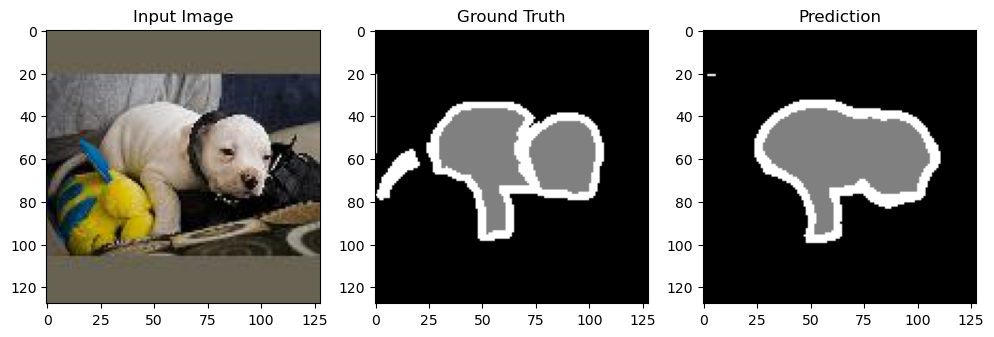

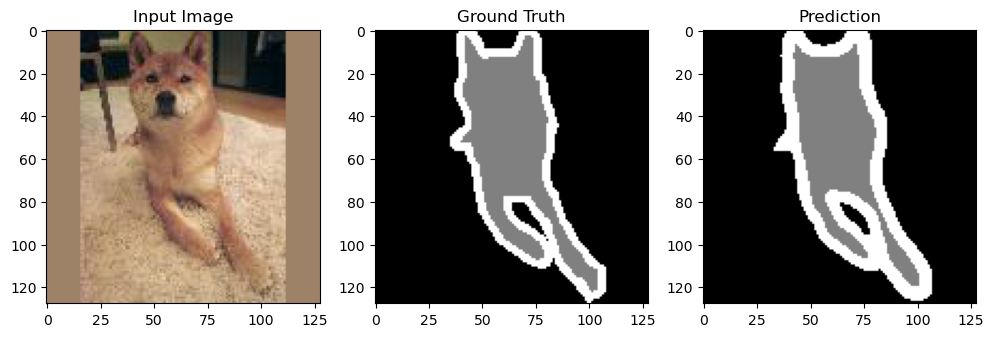

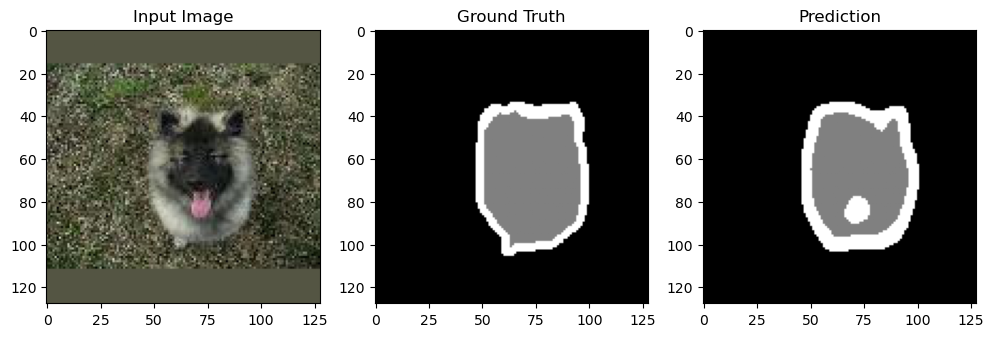

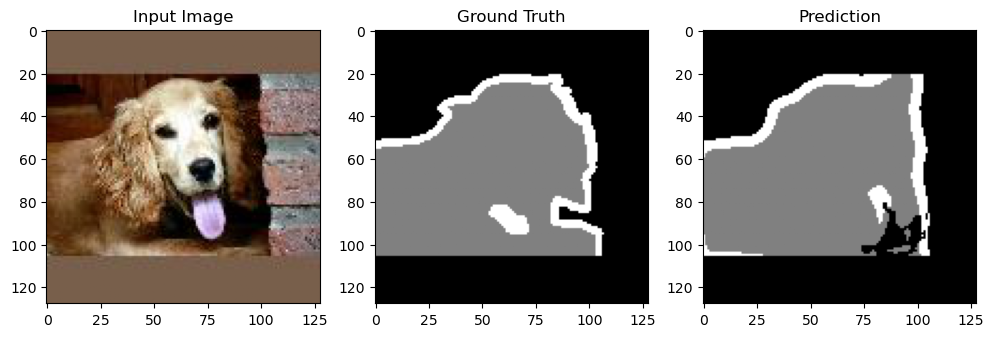

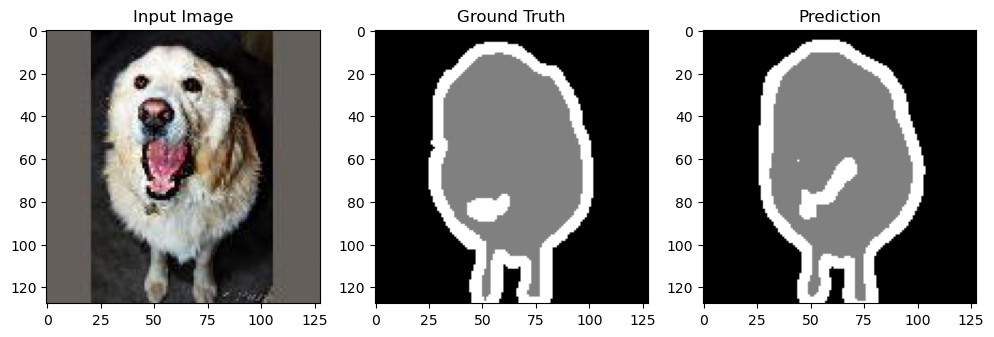

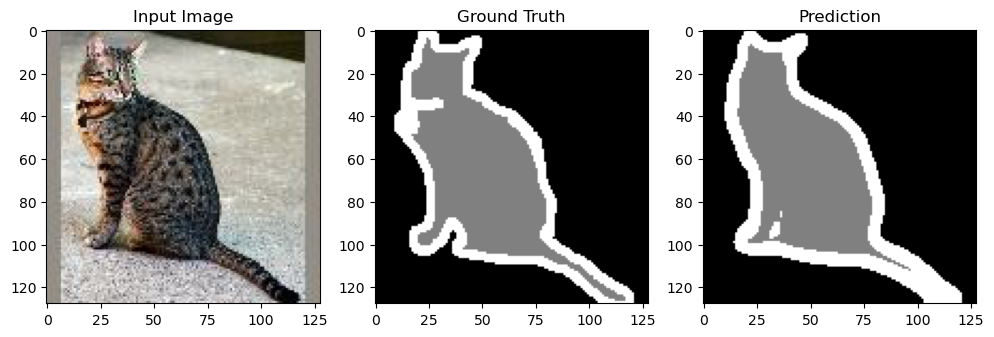

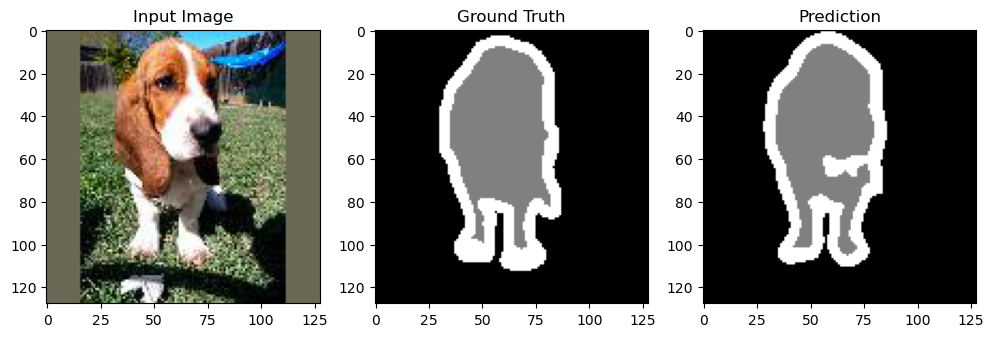

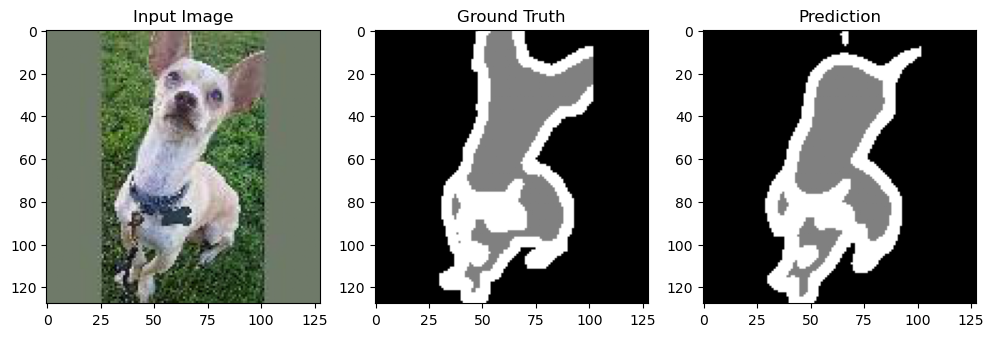

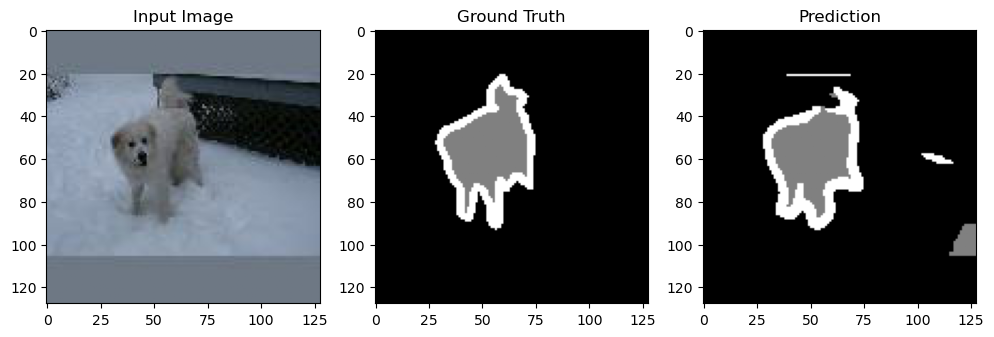

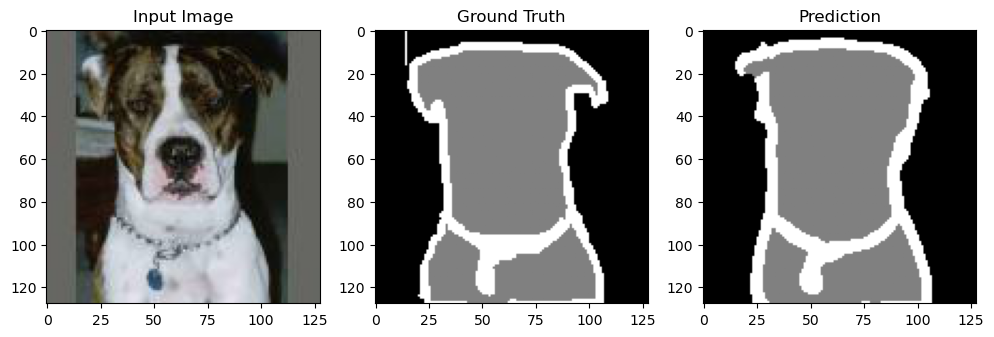

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random  # for random sampling

def test_model(model_path, test_dataset, batch_size=8, num_classes=3):
    device = torch.device("mps")

    # Instantiate and load the model.
    model = UNet(n_channels=3, n_classes=3).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # Use raw logits for loss computation.
    criterion = torch.nn.CrossEntropyLoss()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device).long()  # Ensure targets are long type

            # (Optional) Check target value range:
            if torch.min(targets) < 0 or torch.max(targets) >= num_classes:
                print(f"Target range error: min={torch.min(targets)}, max={torch.max(targets)}")

            outputs = model(images)  # raw logits
            loss = criterion(outputs, targets)
            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    avg_loss = total_loss / len(test_dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    print(f"Test Loss: {avg_loss:.4f}")

    # Compute IoU.
    ious = compute_iou(all_preds, all_targets, num_classes=num_classes)
    avg_iou = np.nanmean(ious)
    print(f"Test IoU: {avg_iou:.4f} (per class: {ious})")

    return avg_loss, all_preds, all_targets, model

def visualize_sample(dataset, model, device, idx=0):
    model.eval()
    img, mask = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).squeeze().cpu().numpy()
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.subplot(1,3,2)
    plt.imshow(mask_np, cmap='gray', vmin=0, vmax=2)
    plt.title("Ground Truth")
    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='gray', vmin=0, vmax=2)
    plt.title("Prediction")
    plt.savefig(f"Unet_Test_{idx}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# --- Main block ---
if __name__ == "__main__":
    # Setup transforms for images and (optionally) for labels.
    transform_img = transforms.Compose([
        transforms.ToTensor(),
    ])
    transform_label = None  # Ensure your label transformation converts the mask to a tensor of type long

    # Replace with your actual test dataset directory.
    # For example, if your test images are in /content/processed/Test/color
    # and masks are in /content/processed/Test/label, adjust the SegmentationDataset accordingly.
    test_dataset = SegmentationDataset(
        root_dir="./Dataset/processed/Test/",
        transform_img=transform_img,
        transform_label=transform_label
    )

    # Optional: check distribution of classes in the test set
    m3 = 0  # count of masks with three classes [0,1,2]
    m2 = 0  # count of masks with two classes [0,1]
    m1 = 0  # count of masks with only one class

    for i in range(len(test_dataset)):
        _, mask_sample = test_dataset[i]
        unique_vals = torch.unique(mask_sample).sort()[0]  # sort to ensure order is [0,1,2] if present
        # Compare against the expected tensors
        if torch.equal(unique_vals, torch.tensor([0, 1, 2])):
            m3 += 1
        elif torch.equal(unique_vals, torch.tensor([0, 1])):
            m2 += 1
        else:
            m1 += 1

    print(f"Distribution of mask classes:")
    print(f"  Masks with 3 classes [0,1,2]: {m3}")
    print(f"  Masks with 2 classes [0,1]:   {m2}")
    print(f"  Masks with 1 class:           {m1}")

    # Path to the saved model (state dictionary)
    model_path = "best_unet_v3.pth"

    # Run the test function. We also retrieve the trained model from here.
    avg_loss, preds, targets, model = test_model(model_path, test_dataset, batch_size=16)

    # Show 10 random samples from the dataset (input, ground truth, prediction).
    device = torch.device("mps")
    import random
    random_indices = random.sample(range(len(test_dataset)), 10)
    for idx in random_indices:
        visualize_sample(test_dataset, model, device, idx)